In [20]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import os 

# Set the seaborn style
sns.set_style("whitegrid")
sns.set_palette("mako")

# Configure Matplotlib to use LaTeX for rendering
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{times}",
    })

In [12]:
def get_reward_score(reward_model, input_text, tokenizer, true_reward=False, show_output=False):
    """
    Takes reward model and input and returns reward score. 
    """
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)#.to(device)
    # reward_model = reward_model.to(device)
    
    if show_output:
        print("REWARD MODEL: " , reward_model(input_ids))

    if true_reward:
        output = reward_model(input_ids).logits
    else:
        output = reward_model(input_ids)

    output = -1*output[:, -1]
    return output

def get_true_reward_model(true_rm = "s-nlp/roberta_toxicity_classifier"):
    """
    Returns true reward model. 
    """
    if true_rm == "s-nlp/roberta_toxicity_classifier":
        # load tokenizer and model weights
        reward_tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
        reward_model = RobertaForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')#.to(device)

        return reward_model, reward_tokenizer

In [13]:
# load dataset
dataset_name = 'jaredjoss/jigsaw-long-2000'
dataset = load_dataset(dataset_name)
df = pd.DataFrame(dataset['train'])
df['full_text'] = df['prompt'] + ' ' + df['original_output']
df

,prompt,original_output,toxic,full_text
0,""" ==Speedy deletion of Mariana Zara== A tag ha...",well as our subject-specific notability guidel...,0,""" ==Speedy deletion of Mariana Zara== A tag ha..."
1,I'm with ^^^ == Speculation == I try my best t...,"and left it, so why are you still moaning? To ...",0,I'm with ^^^ == Speculation == I try my best t...
2,Murali == Please don't revert my edits without...,reasoning - just makes you look stupid. ==,1,Murali == Please don't revert my edits without...
3,""" :::You're a real pair of Nazi-infatuated knu...",have somehow created such a powerful precedenc...,0,""" :::You're a real pair of Nazi-infatuated knu..."
4,The Fresh Meat 2 guide needs to be,deleted because nothing but bullshit is on it.,1,The Fresh Meat 2 guide needs to be deleted bec...
...,...,...,...,...
1995,i think i want to know how the sperm looks lik...,you every know and you guys are come from your...,1,i think i want to know how the sperm looks lik...
1996,== Categorization of Turkish Cypriot politicia...,so big that we broke it up by continent. I sus...,0,== Categorization of Turkish Cypriot politicia...
1997,LOL uncle Dick needs no harassment because hes...,a name that reminds of the male reproductive o...,1,LOL uncle Dick needs no harassment because hes...
1998,":Trolling again, Cwobeel? You need to learn how","to stop shooting off your mouth, right?",1,":Trolling again, Cwobeel? You need to learn ho..."


In [14]:
# Get true reward of dataset from groundtruth model
true_reward_model, true_rm_tokenizer = get_true_reward_model()
df['true_reward'] = df['full_text'].apply(lambda text: get_reward_score(true_reward_model, text, true_rm_tokenizer, true_reward=True).detach().cpu().item())

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# Most and least toxic texts
n_toxic_df = df.sort_values(by='true_reward', ascending=False)[['full_text', 'toxic', 'true_reward']].head(10)
toxic_df = df.sort_values(by='true_reward', ascending=True)[['full_text', 'toxic', 'true_reward']].head(10)

print("Least Toxic Texts: ", n_toxic_df)
print("\nMost Toxic Texts: ", toxic_df)

Least Toxic Texts:                                                full_text  toxic  true_reward
1065  "This statment is not true: ""Even if all huma...      0     5.323374
1351  Only recently did I become aware that there wa...      0     5.322245
53    Well, no, neither can I. Reading through the d...      0     5.322152
1293  Significant contributions in at least one of t...      0     5.315855
676   Yeah that would be an option, but I would call...      0     5.310445
1902  "Under Political Views is a paragraph that sta...      0     5.309896
1744  ":, ""The Impossible trinity (also known as th...      0     5.309404
1407  " Article is simply wrong in several places. T...      0     5.302814
518   It is a very informative article! I have a que...      0     5.301908
1263  " == Description == The AHSA describes itself ...      0     5.296545

Most Toxic Texts:                                                full_text  toxic  true_reward
1246  Derhexer you're a fucking asshole. you pro

## Calculate quantiles for 'true_reward'

In [16]:
quantiles = df['true_reward'].quantile([0.25, 0.5, 0.75, 0.95])

df['reward_category'] = pd.cut(df['true_reward'], 
                               bins=[-np.inf, quantiles[0.25], quantiles[0.5], quantiles[0.75], np.inf],
                               labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])

# group by reward category and toxic flag, then aggregate
analysis = df.groupby(['reward_category', 'toxic']).agg({
    'true_reward': ['mean', 'min', 'max', 'count'],
    'full_text': lambda x: ' || '.join(x.str[:50].sample(min(3, len(x))))  # Sample of first 50 chars of 3 texts
}).reset_index()

analysis.columns = ['_'.join(col).strip() for col in analysis.columns.values]
analysis = analysis.rename(columns={
    'reward_category_': 'reward_category',
    'toxic_': 'toxic',
    'true_reward_mean': 'mean_reward',
    'true_reward_min': 'min_reward',
    'true_reward_max': 'max_reward',
    'true_reward_count': 'count',
    'full_text_<lambda>': 'sample_texts'
})

# Sort by mean reward
analysis_sorted = analysis.sort_values('mean_reward', ascending=False)
analysis_sorted

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_65775/969360978.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby(['reward_category', 'toxic']).agg({


,reward_category,toxic,mean_reward,min_reward,max_reward,count,sample_texts
6,Very Positive,0,5.180749,5.061112,5.323374,500,""" ==Speedy deletion of WinApple Podcast== A ta..."
4,Positive,0,4.123244,1.716839,5.060625,469,"""Why this article is necessary and important I..."
5,Positive,1,2.398476,1.701938,3.860580,31,== Vandalism == This is in reference to your v...
2,Negative,0,0.428081,-1.957223,1.678819,31,""" == Clone (Rapper) == Just shutup and let it ..."
3,Negative,1,-1.692217,-2.809340,1.700486,469,== Photo == Are they admirers of his penis spe...
1,Very Negative,1,-3.344290,-3.936226,-2.810566,500,== Mwhahaha == you are a fucking basted just g...
0,Very Negative,0,NaN,NaN,NaN,0,NaN
7,Very Positive,1,NaN,NaN,NaN,0,NaN


- All Very Positive comments are non-toxic (500 count), with no toxic comments in this category.
- Positive comments are mostly non-toxic (469) with some toxic ones (31).
- Negative comments are mostly toxic (469) with some non-toxic ones (31).
- Very Negative comments are all toxic (500), with no non-toxic comments in this category.

## Distribution of toxic and non-toxic comments across reward categories

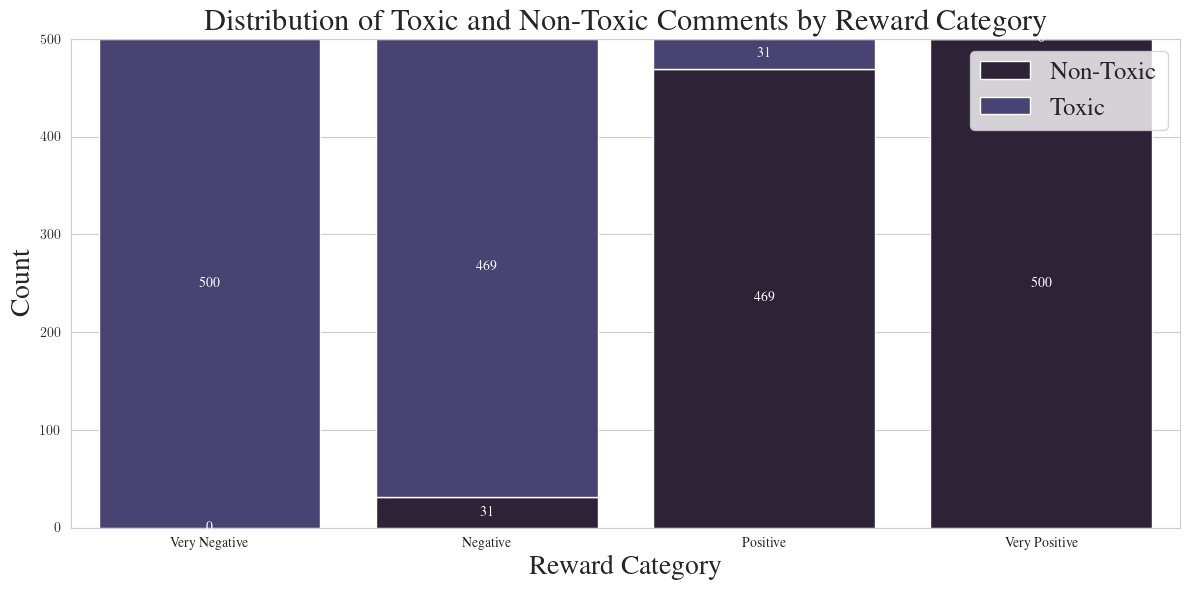

In [21]:
# Pivot the data to get it in the right format for stacking
pivot_data = analysis.pivot(index='reward_category', columns='toxic', values='count').fillna(0)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked bar chart using seaborn
sns.barplot(x=pivot_data.index, y=pivot_data[0], color=sns.color_palette()[0], label='Non-Toxic', ax=ax)
sns.barplot(x=pivot_data.index, y=pivot_data[1], color=sns.color_palette()[1], label='Toxic', bottom=pivot_data[0], ax=ax)

# Customize the plot
plt.title('Distribution of Toxic and Non-Toxic Comments by Reward Category', fontsize=22)
plt.xlabel('Reward Category', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize=18)

# Add value labels on the bars
for i, (index, row) in enumerate(pivot_data.iterrows()):
    if row[0] > 0 or row[1] > 0:
        ax.text(i, row[0]/2, f'{row[0]:.0f}', ha='center', va='center', color='white', fontweight='bold')
        ax.text(i, row[0] + row[1]/2, f'{row[1]:.0f}', ha='center', va='center', color='white', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Mean rewards for toxic and non-toxic comments in each category

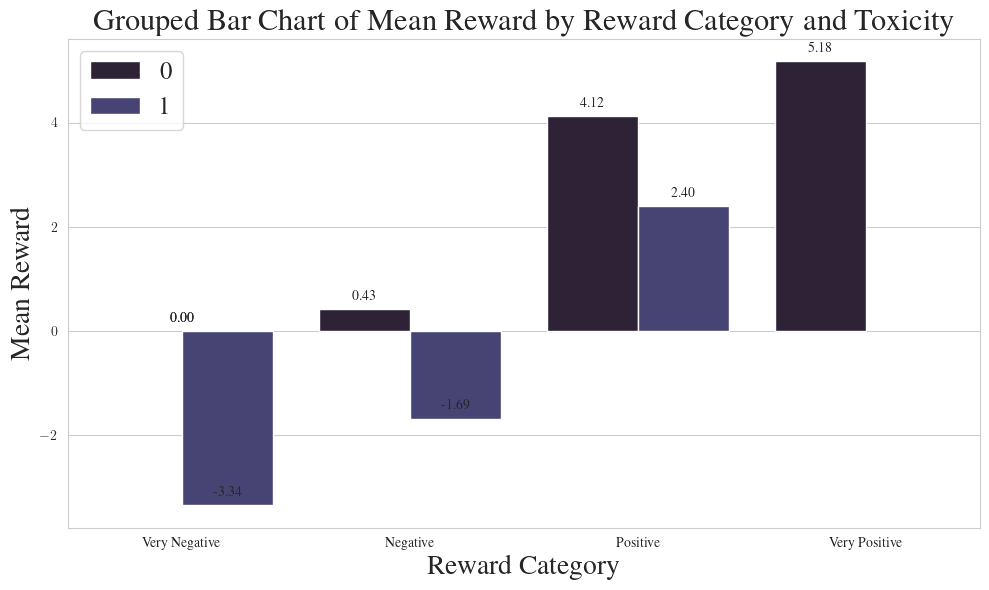

In [22]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='reward_category', y='mean_reward', hue='toxic', data=analysis.dropna(subset=['mean_reward']))

# Annotate the bars with the values
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.title('Grouped Bar Chart of Mean Reward by Reward Category and Toxicity', size=22)
plt.xlabel('Reward Category', size=20)
plt.ylabel('Mean Reward', size=20)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

## Relationship between toxicity and reward value for individual data points

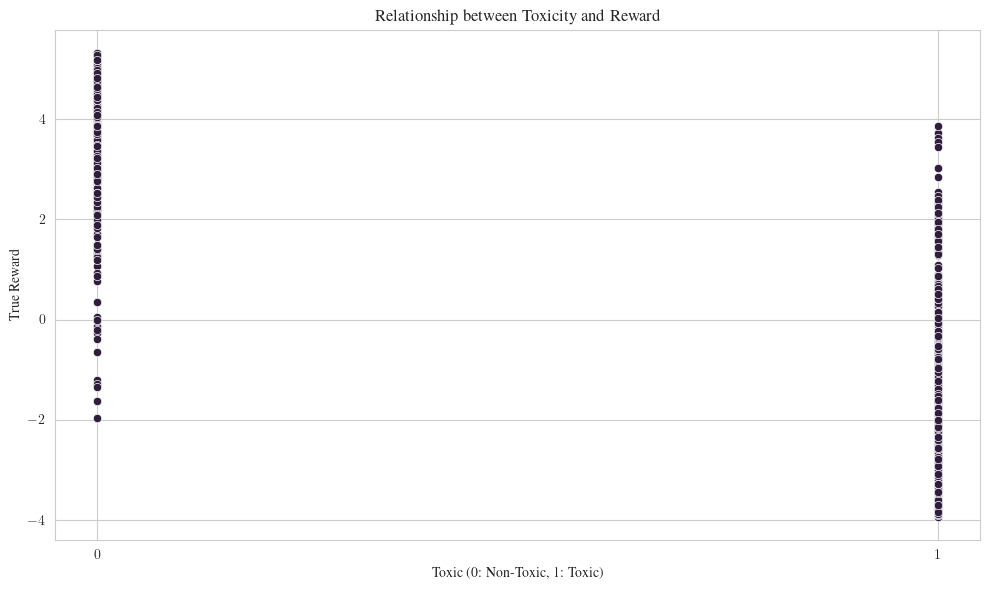

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="toxic", y="true_reward")
plt.title('Relationship between Toxicity and Reward')
plt.xlabel('Toxic (0: Non-Toxic, 1: Toxic)')
plt.ylabel('True Reward')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()